In [2]:
# === Setup ===
!pip install transformers torchtext --quiet

import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import BertTokenizer, BertModel
from google.colab import drive

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# === Mount and Load Data ===
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/ECS 189G/stage_4_data.zip" -d /content/

DATA_DIR = "/content/stage_4_data/text_classification"
RESULTS_DIR = "/content/stage_4_result"
os.makedirs(RESULTS_DIR, exist_ok=True)

def load_classification_data(split_dir):
    data = []
    for label_name, label_val in [('pos', 1), ('neg', 0)]:
        label_dir = os.path.join(split_dir, label_name)
        for fname in os.listdir(label_dir):
            fpath = os.path.join(label_dir, fname)
            if os.path.isfile(fpath) and fname.endswith('.txt'):
                with open(fpath, 'r', encoding='utf-8') as f:
                    text = f.read().strip()
                data.append({'text': text, 'label': label_val})
    return data

# Load data splits
train_data = load_classification_data(os.path.join(DATA_DIR, "train"))
test_data  = load_classification_data(os.path.join(DATA_DIR, "test"))


Streaming output truncated to the last 5000 lines.
  inflating: /content/stage_4_data/text_classification/train/pos/9260_7.txt  
  inflating: /content/__MACOSX/stage_4_data/text_classification/train/pos/._9260_7.txt  
  inflating: /content/stage_4_data/text_classification/train/pos/1599_7.txt  
  inflating: /content/__MACOSX/stage_4_data/text_classification/train/pos/._1599_7.txt  
  inflating: /content/stage_4_data/text_classification/train/pos/2174_8.txt  
  inflating: /content/__MACOSX/stage_4_data/text_classification/train/pos/._2174_8.txt  
  inflating: /content/stage_4_data/text_classification/train/pos/2309_9.txt  
  inflating: /content/__MACOSX/stage_4_data/text_classification/train/pos/._2309_9.txt  
  inflating: /content/stage_4_data/text_classification/train/pos/12034_10.txt  
  inflating: /content/__MACOSX/stage_4_data/text_classification/train/pos/._12034_10.txt  
  inflating: /content/stage_4_data/text_classification/train/pos/11703_9.txt  
  inflating: /content/__MACOSX/

In [3]:
# === BERT Tokenizer and Embedding Function ===
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased').to(device)
bert.eval()

def prepare_bert_embeddings(dataset_list, tokenizer, max_len=128, batch_size=32):
    texts = [d['text'] for d in dataset_list]
    labels = [d['label'] for d in dataset_list]

    encodings = tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )

    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    embeddings = []
    with torch.no_grad():
        for i in range(0, input_ids.size(0), batch_size):
            batch_ids = input_ids[i:i+batch_size]
            batch_mask = attention_mask[i:i+batch_size]
            outputs = bert(input_ids=batch_ids, attention_mask=batch_mask)
            cls_batch = outputs.last_hidden_state[:, 0, :]  # CLS token
            embeddings.append(cls_batch)

    X = torch.cat(embeddings, dim=0)
    y = torch.tensor(labels).to(device)
    return TensorDataset(X, y)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [4]:
# === Prepare DataLoaders ===
print("working")
train_dataset = prepare_bert_embeddings(train_data, tokenizer)
print("working")
test_dataset  = prepare_bert_embeddings(test_data, tokenizer)
print("working")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
print("working")
test_loader  = DataLoader(test_dataset, batch_size=32)
print("working")


working
working
working
working
working


In [9]:
import torch
import torch.nn as nn

class BertGRUClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=24, num_layers=1, num_classes=2, dropout=0.2):
        super(BertGRUClassifier, self).__init__()

        # GRU to reduce overfitting and simplify
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0  # GRU dropout only applies if num_layers > 1
        )

        # Simple FC layer for binary classification
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch_size, seq_len=1, input_dim)
        _, hn = self.gru(x)  # hn shape: (num_layers, batch, hidden_dim)
        x = hn[-1]           # last GRU layer's hidden state
        x = self.dropout(x)
        return self.fc(x)

model = BertGRUClassifier(
    hidden_dim=24,
    dropout=0.2
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=5e-4
)


In [10]:
train_losses = []
train_accuracies = []

def train(model, loader):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy

# === Run Training ===
epochs = 125
for epoch in range(1, epochs + 1):
    loss, acc = train(model, train_loader)
    train_losses.append(loss)
    train_accuracies.append(acc)
    print(f"Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {acc:.4f}")


Epoch 1: Loss = 0.6030, Accuracy = 0.6844
Epoch 2: Loss = 0.4860, Accuracy = 0.7730
Epoch 3: Loss = 0.4601, Accuracy = 0.7872
Epoch 4: Loss = 0.4468, Accuracy = 0.7897
Epoch 5: Loss = 0.4399, Accuracy = 0.7957
Epoch 6: Loss = 0.4338, Accuracy = 0.7991
Epoch 7: Loss = 0.4293, Accuracy = 0.8012
Epoch 8: Loss = 0.4264, Accuracy = 0.8041
Epoch 9: Loss = 0.4201, Accuracy = 0.8079
Epoch 10: Loss = 0.4178, Accuracy = 0.8087
Epoch 11: Loss = 0.4150, Accuracy = 0.8080
Epoch 12: Loss = 0.4104, Accuracy = 0.8128
Epoch 13: Loss = 0.4064, Accuracy = 0.8155
Epoch 14: Loss = 0.4062, Accuracy = 0.8149
Epoch 15: Loss = 0.4038, Accuracy = 0.8150
Epoch 16: Loss = 0.4023, Accuracy = 0.8162
Epoch 17: Loss = 0.3975, Accuracy = 0.8200
Epoch 18: Loss = 0.3954, Accuracy = 0.8210
Epoch 19: Loss = 0.3938, Accuracy = 0.8209
Epoch 20: Loss = 0.3917, Accuracy = 0.8220
Epoch 21: Loss = 0.3889, Accuracy = 0.8242
Epoch 22: Loss = 0.3885, Accuracy = 0.8242
Epoch 23: Loss = 0.3868, Accuracy = 0.8256
Epoch 24: Loss = 0.3

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

def test_model(model, test_loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            pred = torch.argmax(logits, dim=1)
            preds.extend(pred.cpu().numpy())
            targets.extend(y.cpu().numpy())

    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds)
    precision = precision_score(targets, preds)
    recall = recall_score(targets, preds)

    print("\n=== Test Set Evaluation ===")
    print(f"Accuracy  : {acc:.4f}")
    print(f"F1 Score  : {f1:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print("\nClassification Report:")
    print(classification_report(targets, preds, target_names=["Negative", "Positive"]))

# ✅ Run Test Evaluation
test_model(model, test_loader)



=== Test Set Evaluation ===
Accuracy  : 0.8050
F1 Score  : 0.8044
Precision : 0.8069
Recall    : 0.8019

Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.81      0.81     12500
    Positive       0.81      0.80      0.80     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.80      0.80     25000
weighted avg       0.81      0.81      0.80     25000



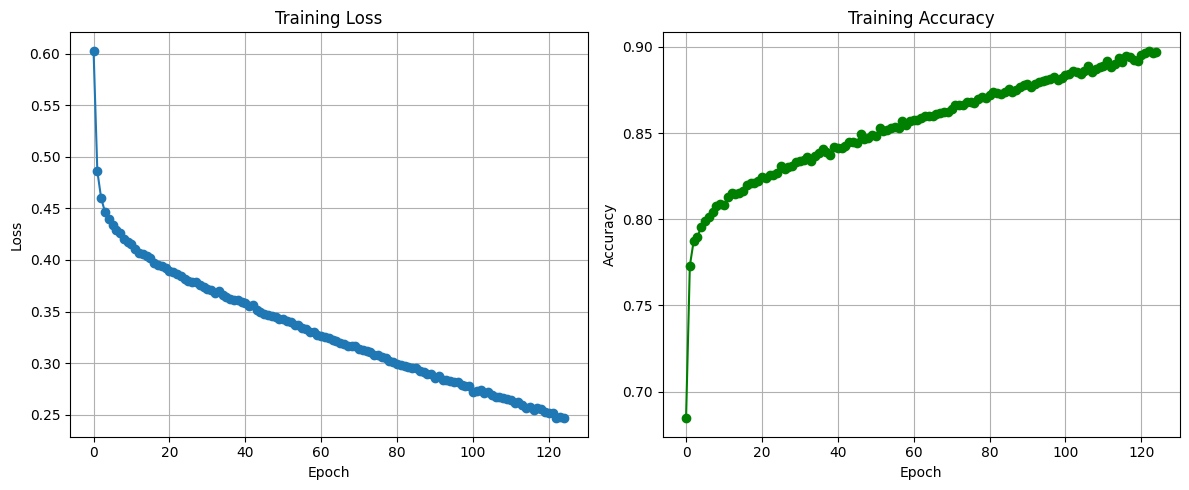

In [14]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o', label='Train Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, marker='o', color='green', label='Train Accuracy')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()
